# Boston housing price dataset

In this section, we'll attempt to predict the median price of homes in a given Boston suburb in the mid-1970s, given data points about the suburb at the time, such as the crime rate, the local property tax rate, and so on. The dataset we'll use has an interesting difference from the two previous examples. It has relatively few data points: only 506, split between 404 training samples and 102 test samples. And each feature in the input data (for example, the crime rate) has a different scale. For instance, some values are proportions, which take values between 0 and 1, others take values between 1 and 12, others between 0 and 100, and so on.

In [1]:
# imports

import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from keras import layers

2024-04-29 16:17:35.120413: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 16:17:35.124067: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-29 16:17:35.171248: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-29 16:17:36.311872: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [ ]:
# Loading the Boston haousing price dataset

(train_data, train_targets), (test_data, test_targets) = tf.keras.datasets.boston_housing.load_data()

It would be problematic to feed into a neural network values that all take wildly different ranges. The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult.

In [ ]:
# Normalizing the data

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data  -= mean
test_data  /= std

Because so few samples are available, we'll use a very small model with two intermediate layers, each with 64 units. In general, the less training data you have, the worse overfitting will be, and using a small model is one way to mitigate overfitting.

In [ ]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1)
        ])
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model

The model ends with a single unit and no activation (it will be a linear layer). This is a typical setup for scalar regression (a regression where you're trying to predict a single continuous value).

Note that we compile the model with the `mse` loss function—*mean squared error*.

We're also monitoring a new metric during training: *mean absolute error* (MAE). It's the absolute value of the difference between the predictions and the targets.

To evaluate our model while we keep adjusting its parameters (such as the number of epochs used for training), we could split the data into a training set and a validation set, as we did in the previous examples. But because we have so few data points, the validation set would end up being very small (for instance, about 100 examples). As a consequence, the validation scores might change a lot depending on which data points we chose for validation and which we chose for training: the validation scores might have a high variance with regard to the validation split. This would prevent us from reliably evaluating our model.

The best practice in such situations is to use *K-fold cross-validation*.

In [ ]:
# K-fold validation

k = 4
num_val_samples = len(train_data) // k
num_epochs = 500
all_mae_histories = []

for i in range(k):

    print(f"Processing fold #{i}")
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0
    )

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0
    )

    model = build_model()

    history = model.fit(
        partial_train_data,
        partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs,
        batch_size=16,
        verbose=0
        )
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)

print('mae history', mae_history)
print('all maea', all_mae_histories)

Processing fold #0
Processing fold #1
Processing fold #2
Processing fold #3
mae history [22.06647300720215, 19.132272720336914, 15.219942092895508, 10.512690544128418, 7.454126358032227, 6.202363967895508, 5.151381492614746, 4.573919773101807, 4.124662399291992, 3.8437843322753906, 3.680284261703491, 3.495096445083618, 3.362758159637451, 3.3162050247192383, 3.2183310985565186, 3.1683497428894043, 3.148322582244873, 3.123117685317993, 3.029404640197754, 3.026210308074951, 2.9127464294433594, 2.840721845626831, 2.9117672443389893, 2.8417694568634033, 2.7839295864105225, 2.733412981033325, 2.8126842975616455, 2.767805576324463, 2.7163710594177246, 2.722975254058838, 2.7063450813293457, 2.750401258468628, 2.619636058807373, 2.7063229084014893, 2.707318067550659, 2.6519060134887695, 2.585096836090088, 2.591811180114746, 2.564685583114624, 2.5533525943756104, 2.8706820011138916, 2.6232082843780518, 2.509521245956421, 2.6086277961730957, 2.552398920059204, 2.4933693408966064, 2.51174545288085

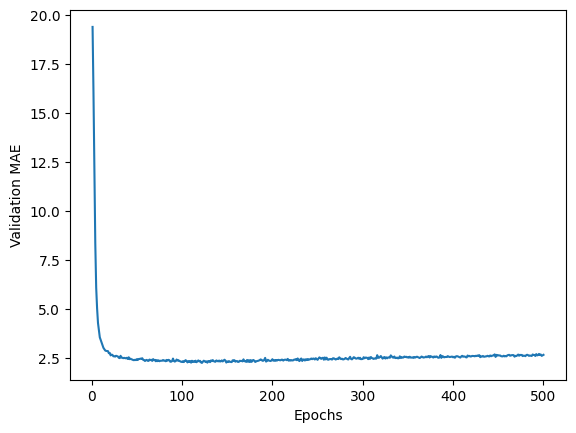

In [ ]:
#  Building the history of successive mean K-fold validation scores

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

It may be a little difficult to read the plot, due to a scaling issue: the validation MAE for the first few epochs is dramatically higher than the values that follow. Let's omit the first 10 data points, which are on a different scale than the rest of the curve.

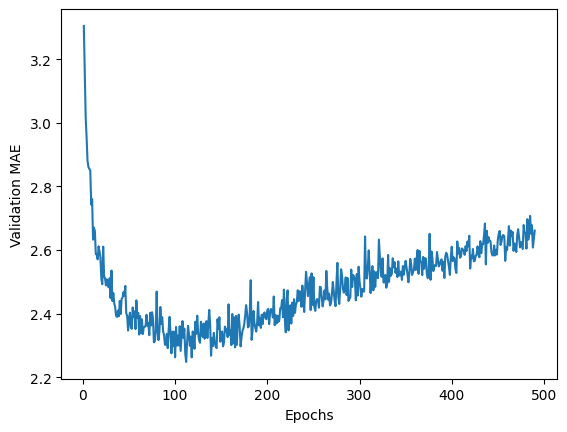

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()